# MSA 深度学习模型

In [1]:
import sys
sys.path.append("/p300s/wangmx_group/xutingfeng/SIS/")


In [2]:

from sis.dataset import SIS_MSADataset
import torch 
# import transformers 


# Step1 dataset load 
# device = try_gpu()
device = "cuda:1"

sisdataset = SIS_MSADataset(root_dir = "/p300s/wangmx_group/xutingfeng/SIS/data/msa_total_data.csv", device = device)
# sisdataset = SIS_MSADataset(root_dir = "/p300s/wangmx_group/xutingfeng/SIS/data/msa_total_data.csv", device = device)


aa_vocab = sisdataset.aa_vocab
sis_datasetDict = sisdataset.dataset_dict

train_dataloader = torch.utils.data.DataLoader(sis_datasetDict["train"], batch_size=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(sis_datasetDict["test"], batch_size=4, shuffle=True)




Using custom data configuration default-25cf8ae19bd6daf0
Reusing dataset csv (/home/xutingfeng/.cache/huggingface/datasets/csv/default-25cf8ae19bd6daf0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-25cf8ae19bd6daf0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-2ff8430349cd8a96.arrow


Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-25cf8ae19bd6daf0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-fb14288b7f2c917c.arrow


Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-25cf8ae19bd6daf0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-37eeedbc7dd983ee.arrow


Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-25cf8ae19bd6daf0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-281efcb2da39b9a3.arrow
Loading cached split indices for dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-25cf8ae19bd6daf0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-389e93295146aaa7.arrow and /home/xutingfeng/.cache/huggingface/datasets/csv/default-25cf8ae19bd6daf0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-38b56db73156af48.arrow


In [122]:
from sis.train import train
from torch import nn 

from torch.utils.tensorboard import SummaryWriter
import os.path as osp
import os 

from sis.dataset.EmbeddingData.parse import load_expasy_embedding_dict, load_meiler_embedding_dict
from sis.model.embedding import EmbeddingLayer, OnehotLayer

from sis.model.sismodel import LinearModel

from sis.utils import modelParametersNum, try_gpu
# Step2 build model
length = sisdataset.SLF_max_length + sisdataset.SRnase_max_length

embedding_layer = EmbeddingLayer(aa_embedding_dict=load_meiler_embedding_dict(), aa_vocab=aa_vocab)  # property embedding 
# embedding_layer = OnehotLayer(len(aa_vocab))  # onehot

model = LinearModel(seq_length=length, EmbeddingLayer = embedding_layer) 

# Step3定义 optim and loss
optim = torch.optim.NAdam(model.parameters(), lr=4e-4)
loss = nn.CrossEntropyLoss()
print(modelParametersNum(model))
## log path and save path
model_name = model.__class__.__name__
log_path = f"/p300s/wangmx_group/xutingfeng/SIS/output/logs/{model_name}"

summaryWriter = SummaryWriter(log_path)  # 使用tensorboard记录loss

save_path = f"/p300s/wangmx_group/xutingfeng/SIS/output/model"
# Step4 train
train(net = model, train_dataIter= train_dataloader, test_dataIter= test_dataloader,loss=loss, optim=optim, summary_writer = summaryWriter, epochs=100, device=device,
 savemodel=False, 
#  save_path = save_path
 )



模型总参数个数：3514
3514
epoch 10 : train: mean loss/per 1.726 acc is 0.667 and time is 403.3857324902022review/per sec
test: loss 0.667 and acc is 0.700
epoch 20 : train: mean loss/per 1.671 acc is 0.750 and time is 444.2530385277373review/per sec
test: loss 0.835 and acc is 0.800
epoch 30 : train: mean loss/per 1.641 acc is 0.778 and time is 453.624896729285review/per sec
test: loss 0.873 and acc is 0.800
epoch 40 : train: mean loss/per 1.477 acc is 0.917 and time is 427.26840145332716review/per sec
test: loss 0.859 and acc is 0.800
epoch 50 : train: mean loss/per 1.470 acc is 0.917 and time is 514.1968861100895review/per sec
test: loss 0.857 and acc is 0.800
epoch 60 : train: mean loss/per 1.426 acc is 0.917 and time is 509.19256216741195review/per sec
test: loss 0.768 and acc is 0.800
epoch 70 : train: mean loss/per 1.414 acc is 0.917 and time is 448.69263822276105review/per sec
test: loss 0.853 and acc is 0.800
epoch 80 : train: mean loss/per 1.449 acc is 0.917 and time is 449.5034279505

In [124]:
from itertools import chain
import pandas as pd 
from sis.train import test, predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

iter_dataloader = train_dataloader

o = predict(iter_dataloader, model).cpu()
label = torch.concat([i["label"] for i in iter_dataloader]).cpu()

def flatten_list(x:list):
    return list(chain.from_iterable(x))
names = flatten_list([zip(i["SLF"], i["SRnase"]) for i in iter_dataloader])

pred = (o>0.5).int().flatten()
# pred = o.flatten()

pd.DataFrame({"names":names, "pred":pred, "label":label})

,names,pred,label
0,"(S11-SLF3, S19-RNase)",0,1
1,"(S11-SLF3, S17-RNase)",0,0
2,"(S7-SLF3, S19-RNase)",0,0
3,"(S5-SLF2, S19-RNase)",1,0
4,"(S9-SLF1, S17-RNase)",0,0
5,"(S9-SLF1, S7-RNase)",0,0
6,"(S5-SLF1, S11-RNase)",1,0
7,"(S5-SLF1, S19-RNase)",1,0
8,"(S5-SLF1, S9-RNase)",0,0
9,"(S11-SLF3, S5-RNase)",1,0


              precision    recall  f1-score   support

       自交不亲和       0.58      0.58      0.58        24
        自交亲和       0.17      0.17      0.17        12

    accuracy                           0.44        36
   macro avg       0.38      0.38      0.38        36
weighted avg       0.44      0.44      0.44        36



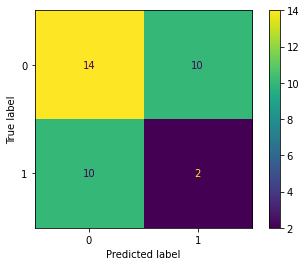

In [125]:
from sklearn.metrics import classification_report

disp = ConfusionMatrixDisplay(confusion_matrix(label, pred), display_labels=[0, 1])
disp.plot()

print(classification_report(label, pred, target_names=["自交不亲和", "自交亲和"]))




,names,pred,label
0,"(S11-SLF2, S7-RNase)",1,0
1,"(S11-SLF1, S19-RNase)",0,0
2,"(S9-SLF1, S19-RNase)",1,0
3,"(S7-SLF1, S19-RNase)",0,0
4,"(S7-SLF2, S17-RNase)",0,0
5,"(S11-SLF2, S5-RNase)",0,0
6,"(S7-SLF1, S17-RNase)",0,0
7,"(S11-SLF1, S17-RNase)",0,1
8,"(S7-SLF1, S5-RNase)",0,1
9,"(S7-SLF3, S11-RNase)",0,0


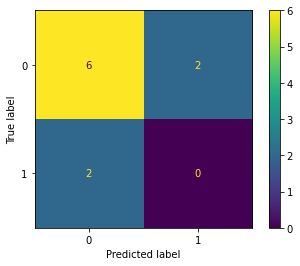

In [7]:
from itertools import chain
import pandas as pd 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

iter_dataloader = test_dataloader

o = predict(iter_dataloader, model)
label = torch.concat([i["label"] for i in iter_dataloader]).cpu()

def flatten_list(x:list):
    return list(chain.from_iterable(x))
names = flatten_list([zip(i["SLF"], i["SRnase"]) for i in iter_dataloader])

pred = (o>0.5).int().flatten()
disp = ConfusionMatrixDisplay(confusion_matrix(label, pred), display_labels=[0, 1])
disp.plot()

pd.DataFrame({"names":names, "pred":pred, "label":label})

/p300s/wangmx_group/xutingfeng/tmp/ipykernel_737/138427600.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  w = F.softmax(w).numpy()


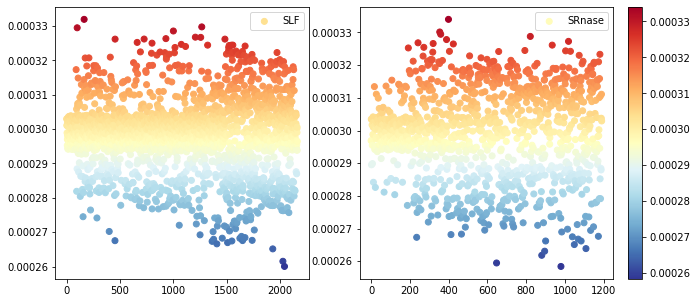

In [9]:
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np 
import torch.nn.functional as F 

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax



# show 最后一层的w

w = model.fc2.weight.flatten().cpu().detach()
w = F.softmax(w).numpy()

cmap1 = cm.RdYlBu_r

w_SLF = w[:sisdataset.SLF_max_length]
w_SRnase = w[-sisdataset.SRnase_max_length:]

fig, axes = plt.subplots(1, 2,figsize=(10, 5))

axes[0].scatter(range(0, sisdataset.SLF_max_length), w_SLF, label="SLF", c=w_SLF,cmap= cmap1)
axes[0].legend()

im = axes[1].scatter(range(0, sisdataset.SRnase_max_length), w_SRnase, label="SRnase", c=w_SRnase, cmap = cmap1)
axes[1].legend()

cax = add_right_cax(axes[1], pad=0.02, width=0.02)
cbar = fig.colorbar(im, cax=cax)

plt.show()

tensor([0, 0, 0, 0], device='cuda:1', dtype=torch.int32)
[tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(0, device='cuda:1')]
tensor([0, 0, 1, 0], device='cuda:1', dtype=torch.int32)
[tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(1, device='cuda:1'), tensor(0, device='cuda:1')]
tensor([0, 1, 0, 1], device='cuda:1', dtype=torch.int32)
[tensor(1, device='cuda:1'), tensor(1, device='cuda:1'), tensor(0, device='cuda:1'), tensor(1, device='cuda:1')]
tensor([0, 0, 1, 0], device='cuda:1', dtype=torch.int32)
[tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(1, device='cuda:1'), tensor(0, device='cuda:1')]
tensor([1, 0, 0, 1], device='cuda:1', dtype=torch.int32)
[tensor(1, device='cuda:1'), tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(1, device='cuda:1')]
tensor([1, 0, 0, 1], device='cuda:1', dtype=torch.int32)
[tensor(1, device='cuda:1'), tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(1

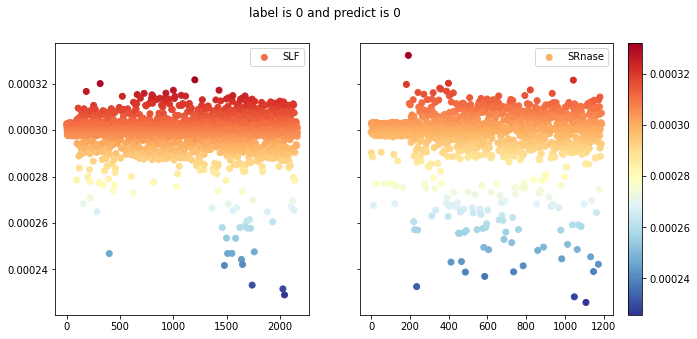

In [12]:
# extract score paired with SLF_Seq and SRnase_Seq

score_tuple = []

for x in train_dataloader:
    o = model(x, return_scores=True)

    SLF_Seq = list(map(aa_vocab.lookup_tokens, x["SLF_Seq_token"].cpu().detach().numpy().tolist()))
    SRnase_Seq = list(map(aa_vocab.lookup_tokens, x["SRnase_Seq_token"].cpu().detach().numpy().tolist()))
    label = list(x["label"])
    pred = (o>0.5).int().flatten()
    print(pred)
    print(label)
    scores = model.scores.cpu().detach().numpy()
    [score_tuple.append([SLF_seq, SRnase_seq, score, l,p ]) for SLF_seq, SRnase_seq, score,l, p in zip(SLF_Seq, SRnase_Seq, scores, label, pred)]
    
import torch.nn.functional as F 

idx = 3

cmap1 = cm.RdYlBu_r

SLF_seq, SRnase_seq, score,l, p = score_tuple[idx]

# calculate score * w 
w = model.fc2.weight.flatten().cpu().detach().numpy()
score = score * w

score = F.softmax(torch.tensor(score),dim=-1).numpy()

SLF_seq_length = len(SLF_seq)
SRnase_seq_length = len(SRnase_seq)

score_SLF = score[:SLF_seq_length]
score_SRnase = score[-SRnase_seq_length:]

fig, axes = plt.subplots(1, 2,figsize=(10, 5),sharey=True)

axes[0].scatter(range(0, SLF_seq_length), score_SLF, label="SLF", c=score_SLF,cmap= cmap1)
axes[0].legend()

im = axes[1].scatter(range(0, SRnase_seq_length), score_SRnase, label="SRnase", c=score_SRnase, cmap = cmap1)
axes[1].legend()

cax = add_right_cax(axes[1], pad=0.02, width=0.02)
cbar = fig.colorbar(im, cax=cax)
plt.suptitle(f"label is {l} and predict is {p}")
plt.show()



## 卷积

In [113]:
import importlib 


importlib.reload(sismodel)

<module 'sis.model.sismodel' from '/p300s/wangmx_group/xutingfeng/SIS/sis/model/sismodel.py'>

In [130]:
from sis.train import train
from torch import nn 

from torch.utils.tensorboard import SummaryWriter
import os.path as osp
import os 

from sis.dataset.EmbeddingData.parse import load_expasy_embedding_dict, load_meiler_embedding_dict
from sis.model.embedding import EmbeddingLayer, OnehotLayer

from sis.model.sismodel import ConvModel

from sis.utils import modelParametersNum, try_gpu
# Step2 build model
length = sisdataset.SLF_max_length + sisdataset.SRnase_max_length

embedding_layer = EmbeddingLayer(aa_embedding_dict=load_meiler_embedding_dict(), aa_vocab=aa_vocab)  # property embedding 
# embedding_layer = OnehotLayer(len(aa_vocab))  # onehot

model = ConvModel(seq_length=length, EmbeddingLayer = embedding_layer) 

# Step3定义 optim and loss
optim = torch.optim.NAdam(model.parameters(), lr=3e-4)
loss = nn.CrossEntropyLoss()
print(modelParametersNum(model))
## log path and save path
model_name = model.__class__.__name__
log_path = f"/p300s/wangmx_group/xutingfeng/SIS/output/logs/{model_name}"

summaryWriter = SummaryWriter(log_path)  # 使用tensorboard记录loss

save_path = f"/p300s/wangmx_group/xutingfeng/SIS/output/model"
# Step4 train
train(net = model, train_dataIter= train_dataloader, test_dataIter= test_dataloader,loss=loss, optim=optim, summary_writer = summaryWriter, epochs=100, device=device,
 savemodel=False, 
#  save_path = save_path
 )



模型总参数个数：4467
4467
epoch 10 : train: mean loss/per 1.848 acc is 0.694 and time is 383.7267570699575review/per sec
test: loss 0.924 and acc is 0.700
epoch 20 : train: mean loss/per 1.846 acc is 0.694 and time is 386.90164425893045review/per sec
test: loss 0.924 and acc is 0.700
epoch 30 : train: mean loss/per 1.654 acc is 0.722 and time is 396.48493569376683review/per sec
test: loss 0.965 and acc is 0.800
epoch 40 : train: mean loss/per 1.612 acc is 0.917 and time is 399.3740567447544review/per sec
test: loss 0.646 and acc is 0.800
epoch 50 : train: mean loss/per 1.505 acc is 0.944 and time is 403.6736710403901review/per sec
test: loss 0.709 and acc is 0.800
epoch 60 : train: mean loss/per 1.515 acc is 0.944 and time is 392.22624159347896review/per sec
test: loss 0.832 and acc is 0.800
epoch 70 : train: mean loss/per 1.459 acc is 0.944 and time is 403.89178547545805review/per sec
test: loss 0.819 and acc is 0.800
epoch 80 : train: mean loss/per 1.499 acc is 0.944 and time is 337.86734570

In [131]:
from itertools import chain
import pandas as pd 
from sis.train import test, predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

iter_dataloader = train_dataloader

o = predict(iter_dataloader, model).cpu()
label = torch.concat([i["label"] for i in iter_dataloader]).cpu()

def flatten_list(x:list):
    return list(chain.from_iterable(x))
names = flatten_list([zip(i["SLF"], i["SRnase"]) for i in iter_dataloader])

pred = (o>0.5).int().flatten()
# pred = o.flatten()

pd.DataFrame({"names":names, "pred":pred, "label":label})

,names,pred,label
0,"(S7-SLF2, S5-RNase)",0,0
1,"(S11-SLF3, S7-RNase)",0,1
2,"(S5-SLF2, S7-RNase)",0,1
3,"(S5-SLF1, S17-RNase)",1,0
4,"(S5-SLF2, S9-RNase)",0,0
5,"(S11-SLF2, S19-RNase)",1,0
6,"(S11-SLF3, S19-RNase)",0,0
7,"(S5-SLF2, S19-RNase)",0,1
8,"(S11-SLF2, S17-RNase)",0,1
9,"(S11-SLF1, S5-RNase)",1,1


              precision    recall  f1-score   support

       自交不亲和       0.62      0.67      0.64        24
        自交亲和       0.20      0.17      0.18        12

    accuracy                           0.50        36
   macro avg       0.41      0.42      0.41        36
weighted avg       0.48      0.50      0.49        36



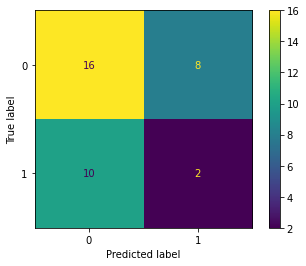

In [132]:
from sklearn.metrics import classification_report

disp = ConfusionMatrixDisplay(confusion_matrix(label, pred), display_labels=[0, 1])
disp.plot()

print(classification_report(label, pred, target_names=["自交不亲和", "自交亲和"]))




,names,pred,label
0,"(S11-SLF1, S17-RNase)",0,0
1,"(S11-SLF2, S5-RNase)",0,0
2,"(S7-SLF1, S17-RNase)",0,1
3,"(S7-SLF1, S19-RNase)",0,0
4,"(S9-SLF1, S19-RNase)",0,0
5,"(S7-SLF2, S17-RNase)",0,0
6,"(S7-SLF1, S5-RNase)",1,1
7,"(S11-SLF2, S7-RNase)",1,0
8,"(S11-SLF1, S19-RNase)",0,0
9,"(S7-SLF3, S11-RNase)",0,0


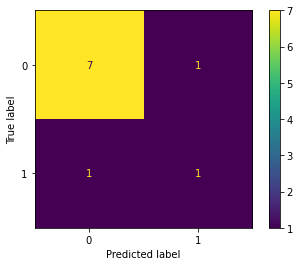

In [133]:
from itertools import chain
import pandas as pd 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

iter_dataloader = test_dataloader

o = predict(iter_dataloader, model)
label = torch.concat([i["label"] for i in iter_dataloader]).cpu()

def flatten_list(x:list):
    return list(chain.from_iterable(x))
names = flatten_list([zip(i["SLF"], i["SRnase"]) for i in iter_dataloader])

pred = (o>0.5).int().flatten()
disp = ConfusionMatrixDisplay(confusion_matrix(label, pred), display_labels=[0, 1])
disp.plot()

pd.DataFrame({"names":names, "pred":pred, "label":label})

/p300s/wangmx_group/xutingfeng/tmp/ipykernel_27904/138427600.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  w = F.softmax(w).numpy()


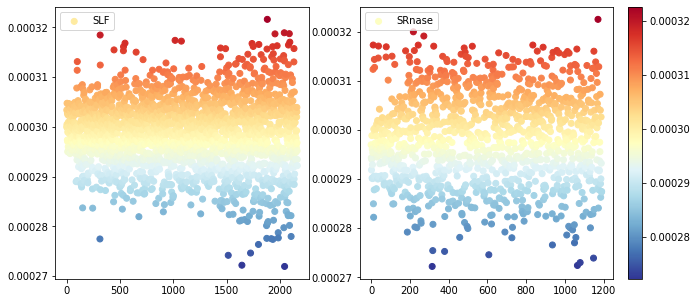

In [120]:
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np 
import torch.nn.functional as F 

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax



# show 最后一层的w

w = model.fc2.weight.flatten().cpu().detach()
w = F.softmax(w).numpy()

cmap1 = cm.RdYlBu_r

w_SLF = w[:sisdataset.SLF_max_length]
w_SRnase = w[-sisdataset.SRnase_max_length:]

fig, axes = plt.subplots(1, 2,figsize=(10, 5))

axes[0].scatter(range(0, sisdataset.SLF_max_length), w_SLF, label="SLF", c=w_SLF,cmap= cmap1)
axes[0].legend()

im = axes[1].scatter(range(0, sisdataset.SRnase_max_length), w_SRnase, label="SRnase", c=w_SRnase, cmap = cmap1)
axes[1].legend()

cax = add_right_cax(axes[1], pad=0.02, width=0.02)
cbar = fig.colorbar(im, cax=cax)

plt.show()

tensor([0, 0, 0, 0], device='cuda:1', dtype=torch.int32)
[tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(0, device='cuda:1')]
tensor([0, 0, 1, 0], device='cuda:1', dtype=torch.int32)
[tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(1, device='cuda:1'), tensor(0, device='cuda:1')]
tensor([0, 0, 0, 0], device='cuda:1', dtype=torch.int32)
[tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(0, device='cuda:1')]
tensor([0, 0, 1, 0], device='cuda:1', dtype=torch.int32)
[tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(1, device='cuda:1'), tensor(0, device='cuda:1')]
tensor([0, 0, 0, 1], device='cuda:1', dtype=torch.int32)
[tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(0, device='cuda:1'), tensor(1, device='cuda:1')]
tensor([0, 1, 0, 1], device='cuda:1', dtype=torch.int32)
[tensor(0, device='cuda:1'), tensor(1, device='cuda:1'), tensor(1, device='cuda:1'), tensor(1

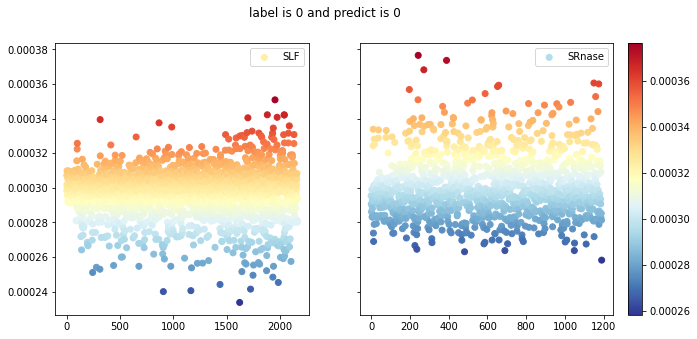

In [121]:
# extract score paired with SLF_Seq and SRnase_Seq

score_tuple = []

for x in train_dataloader:
    o = model(x, return_scores=True)

    SLF_Seq = list(map(aa_vocab.lookup_tokens, x["SLF_Seq_token"].cpu().detach().numpy().tolist()))
    SRnase_Seq = list(map(aa_vocab.lookup_tokens, x["SRnase_Seq_token"].cpu().detach().numpy().tolist()))
    label = list(x["label"])
    pred = (o>0.5).int().flatten()
    print(pred)
    print(label)
    scores = model.scores.cpu().detach().numpy()
    [score_tuple.append([SLF_seq, SRnase_seq, score, l,p ]) for SLF_seq, SRnase_seq, score,l, p in zip(SLF_Seq, SRnase_Seq, scores, label, pred)]
    
import torch.nn.functional as F 

idx = 3

cmap1 = cm.RdYlBu_r

SLF_seq, SRnase_seq, score,l, p = score_tuple[idx]

# calculate score * w 
w = model.fc2.weight.flatten().cpu().detach().numpy()
score = score * w

score = F.softmax(torch.tensor(score),dim=-1).numpy()

SLF_seq_length = len(SLF_seq)
SRnase_seq_length = len(SRnase_seq)

score_SLF = score[:SLF_seq_length]
score_SRnase = score[-SRnase_seq_length:]

fig, axes = plt.subplots(1, 2,figsize=(10, 5),sharey=True)

axes[0].scatter(range(0, SLF_seq_length), score_SLF, label="SLF", c=score_SLF,cmap= cmap1)
axes[0].legend()

im = axes[1].scatter(range(0, SRnase_seq_length), score_SRnase, label="SRnase", c=score_SRnase, cmap = cmap1)
axes[1].legend()

cax = add_right_cax(axes[1], pad=0.02, width=0.02)
cbar = fig.colorbar(im, cax=cax)
plt.suptitle(f"label is {l} and predict is {p}")
plt.show()

